In [2]:
import faiss
import numpy as np
import json
import urllib.request
import pandas as pd
from PIL import Image

In [2]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# device

In [1]:
%%time
import open_clip
import torch
torch.set_grad_enabled(False)
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
# model = model.to(device)

/Users/gautam/Documents/Husn/Fashion/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/gautam/Documents/Husn/Fashion/.venv/lib/python3.11/site-packages/open_clip/factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via 

CPU times: user 5.23 s, sys: 515 ms, total: 5.74 s
Wall time: 3.38 s


In [3]:
image_embeddings_path = "../image_embeddings_normalized.pt"
image_embeddings_tensor = torch.load(image_embeddings_path)

/var/folders/qs/bs3kx40d05bgky9p0c4bwym40000gn/T/ipykernel_90996/1291377798.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_embeddings_tensor = torch.load(image_em

In [4]:
index = faiss.IndexFlatIP(512)
index.add(image_embeddings_tensor.detach().numpy())

In [5]:
import os
DEMO_JSON_PATH = "../accel_demo.json"
IMAGES_DIR = "../accel_images"
if not os.path.exists(IMAGES_DIR):
    os.makedirs(IMAGES_DIR)

CDN_BASE_URL = 'https://husnstorage.z30.web.core.windows.net/'
with open(DEMO_JSON_PATH, 'r') as file:
    demo_data = json.load(file)

In [6]:
image_urls = []
for demo in demo_data[1:]:
    image_urls += [f"{CDN_BASE_URL}{key}" for key in demo['generated_photos']]

for url in image_urls:
    try:
        urllib.request.urlretrieve(url, f"{IMAGES_DIR}/{url.split('/')[-1]}")
    except Exception as e:
        print(f"{url} raised {e}")

In [7]:
import os
images = [Image.open(f"{IMAGES_DIR}/{path}") for path in sorted(os.listdir(IMAGES_DIR))]
file_name_to_index = {name: i for i, name in enumerate(sorted(os.listdir(IMAGES_DIR)))}

In [8]:
batch_images = [preprocess(image).unsqueeze(0) for image in images]
batch_images = torch.cat(batch_images, 0)
batch_features = model.encode_image(batch_images)
torch.save(batch_features, f"../accel_image_embeddings.pt")

In [7]:
# batch_features = torch.load(f"../accel_image_embeddings.pt")

/var/folders/qs/bs3kx40d05bgky9p0c4bwym40000gn/T/ipykernel_78327/1943940635.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch_features = torch.load(f"../accel_image_

In [9]:
all_similar_indices = []
for feature in batch_features:
    similarities, indexes = index.search(feature.unsqueeze(0),  128)
    all_similar_indices.append(indexes[0])

In [10]:
# for data in demo_data[0]:
#     for element in data['generated_photos']:
#         file_name = element['url'].split('/')[-1]
#         element['similar_products_indices'] = all_similar_indices[file_name_to_index[file_name]].tolist()
similar_products_dict = {}
for file_name, id in file_name_to_index.items():
    similar_products_dict[file_name] = {
        "generated_image_url": f"{CDN_BASE_URL}{file_name}",
        "similar_products_indices": all_similar_indices[id].tolist()
    }

In [11]:
demo_data[0] = similar_products_dict
with open(DEMO_JSON_PATH, 'w') as f:
    json.dump(demo_data, f, indent=4)

In [11]:
df = pd.read_csv("../products_minimal.csv")

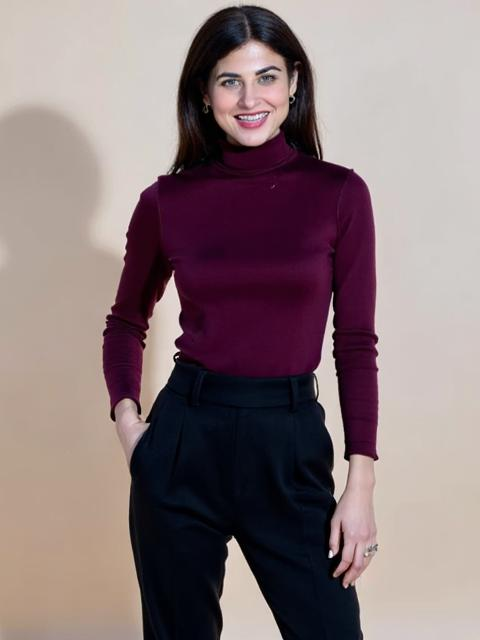

In [12]:
original_img_key = os.listdir(IMAGES_DIR)[8]
original_img = Image.open(f"{IMAGES_DIR}/{original_img_key}")
original_img

In [22]:
!pip install matplotlib

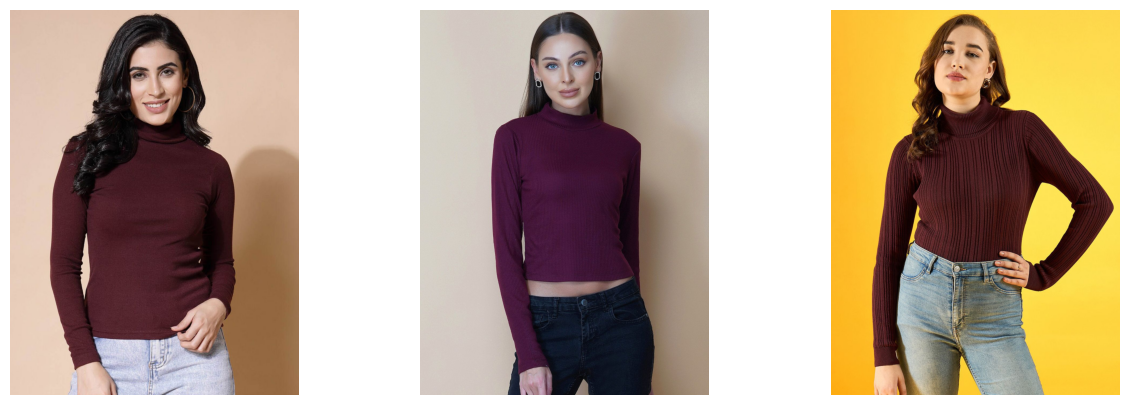

In [13]:
product_ids = demo_data[0][original_img_key]["similar_products_indices"]
products = df.iloc[product_ids].to_dict('records')
urls = [product['primary_image'] for product in products]

import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
from io import BytesIO

# Load the first 3 images from the URLs
images = []
for url in urls[:3]:
    with urllib.request.urlopen(url) as response:
        image_data = response.read()
    image = Image.open(BytesIO(image_data))
    images.append(image)

# Plot the images in a single row
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, img in zip(axes, images):
    ax.imshow(img)
    ax.axis('off')  # Hide the axes

plt.show()
